<a href="https://colab.research.google.com/github/s-shostak-UCU/russain_propaganda_analysis/blob/main/research_ru_propaganda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of russian propaganda dataset


## Data loading

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **Note!!**
Change path to the data, if want to reuse the code for analysis

In [ ]:
import json

# Load channel names from the JSON file
with open('/content/gdrive/My Drive/Colab Notebooks/channels/channels_list.json', 'r') as file:
    channel_data = json.load(file)
    channel_names = channel_data['names']

## **General Analysis**

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [ ]:
data = {
    'channel': [],
    'num_posts': [],
    'num_comments': [],
    'avg_views': [],
    'median_views': []
}

# Loop through each channel and aggregate metrics
for channel in channel_names:
    try:
        # Change path to the data, if want to reuse the code for analysis
        df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")

        if 'to_id' not in df.columns:
            print(f"Column 'to_id' not found in {channel}. Skipping to the next file.")
            continue

        # Filter posts and comments
        posts = df[df['views'].notna()]
        comments = df[df['views'].isna()]

        # Aggregate metrics
        data['channel'].append(channel)
        data['num_posts'].append(len(posts))
        data['num_comments'].append(len(comments))
        data['avg_views'].append(posts['views'].mean())
        data['median_views'].append(posts['views'].median())

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue


# Convert the data dictionary to a DataFrame
aggregated_df = pd.DataFrame(data)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set_style("whitegrid")

# Function to annotate bars with values
def annotate_bars(ax, precision=0):
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.{precision}f}',
                    (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='left', va='center',
                    xytext=(5,0), textcoords='offset points')


### Which channels are the most popular?


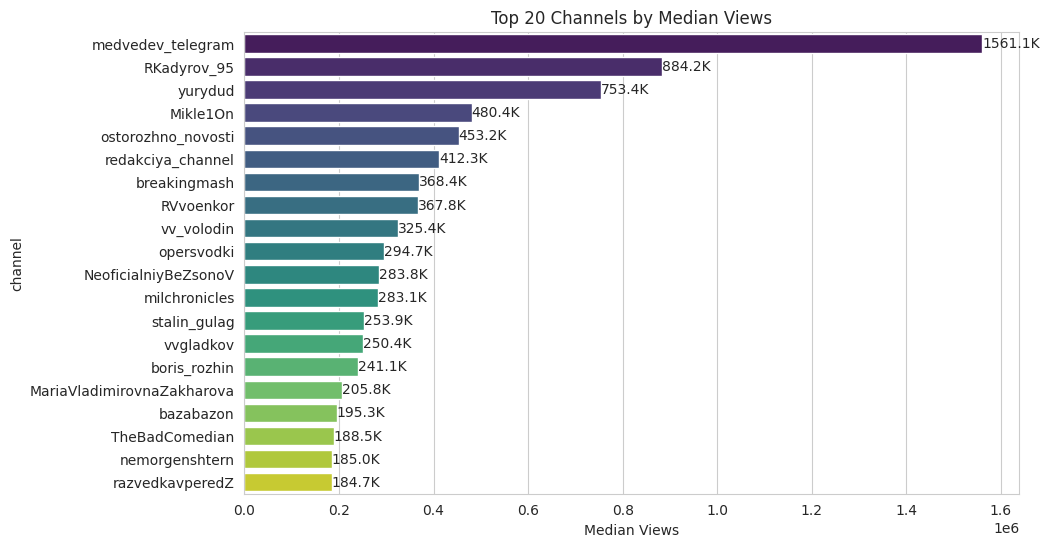

In [ ]:
# Plot 2: Top 20 channels by median views
top_median_views = aggregated_df.nlargest(20, 'median_views')
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(data=top_median_views, y='channel', x='median_views', palette="viridis")
ax2.set_title('Top 20 Channels by Median Views')
ax2.set_xlabel('Median Views')
# Function to format the number with 'K' for thousands
def format_number(num):
    if num >= 1000:
        return f'{num/1000:.1f}K'
    else:
        return str(num)

# Annotate each bar with its respective value
for p in ax2.patches:
    width = p.get_width()
    formatted_width = format_number(width)
    ax2.text(width + 5,  # set the text at 5 unit right of the bar
            p.get_y() + p.get_height() / 2,  # get Y coordinate + X coordinate / 2
            formatted_width,  # formatted value
            ha="left",  # horizontal alignment
            va="center")  # vertical alignment
plt.show()



- In this top, you can see channels from russian politicians, bloggers, and some media channels. By the way, a hypothesis can be tested: is there a significant difference in views from media from "personal" channels? What is more popular, "personal" or media channels? By media, I assume news channels.

- The median is used as a metric instead of the average because the distribution of views is right-skewed. We will see it in the figures below.

### Which channels have the most posts?


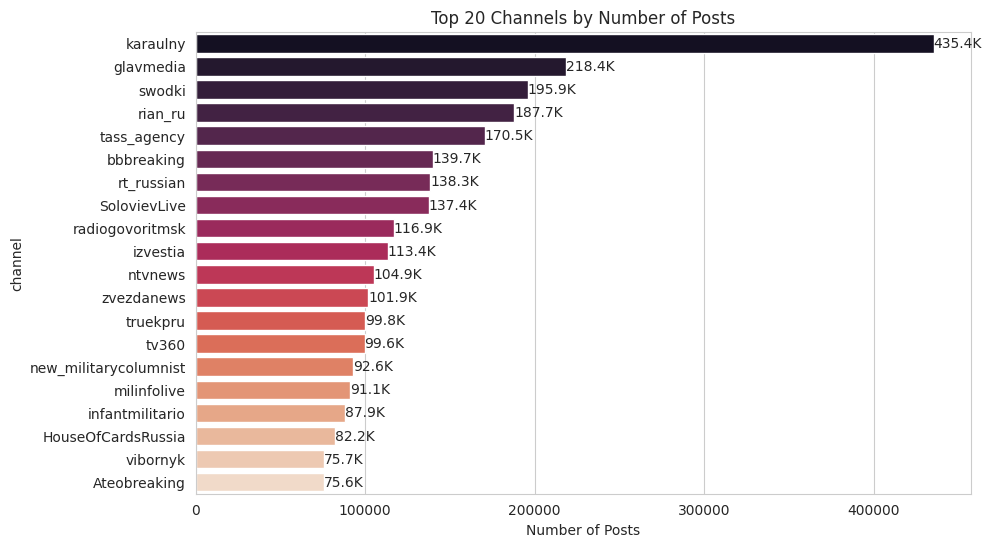

In [ ]:
# Plot 3: Top 20 channels by number of posts
top_posts = aggregated_df.nlargest(20, 'num_posts')
plt.figure(figsize=(10, 6))
ax3 = sns.barplot(data=top_posts, y='channel', x='num_posts', palette="rocket")
ax3.set_title('Top 20 Channels by Number of Posts')
ax3.set_xlabel('Number of Posts')
# Function to format the number with 'K' for thousands
def format_number(num):
    if num >= 1000:
        return f'{num/1000:.1f}K'
    else:
        return str(num)

# Annotate each bar with its respective value
for p in ax3.patches:
    width = p.get_width()
    formatted_width = format_number(width)
    ax3.text(width + 5,  # set the text at 5 unit right of the bar
            p.get_y() + p.get_height() / 2,  # get Y coordinate + X coordinate / 2
            formatted_width,  # formatted value
            ha="left",  # horizontal alignment
            va="center")  # vertical alignment
plt.show()



- In this top, you can see mostly some media channels and standalone soloviev channel.

- Assumed some channels make small text posts or pictures/videos frequently, which is why channels have so many posts. Anyway, this assumption should be tested before jumping to conclusions.  

### Which channels have the most commented posts?

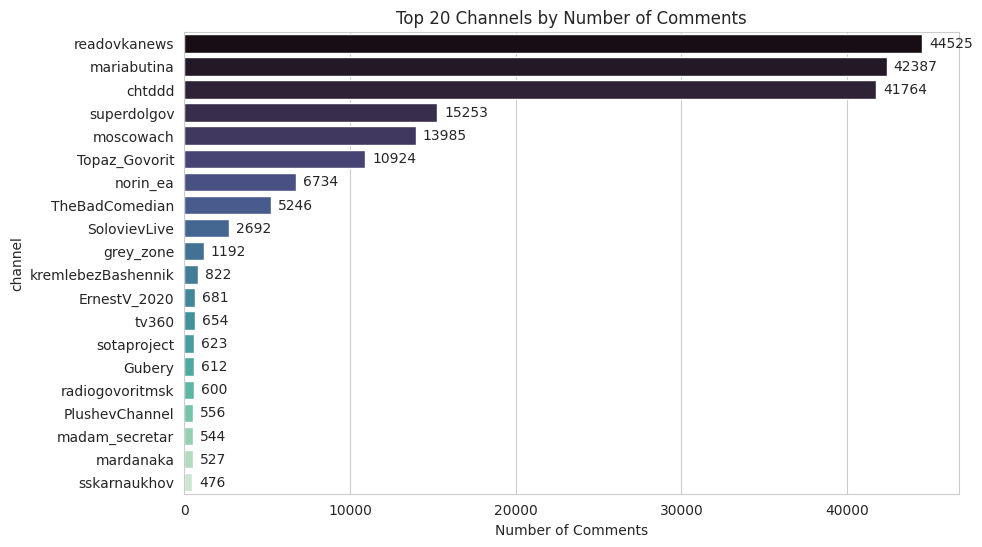

In [ ]:
# Plot 4: Top 20 channels by number of comments
top_comments = aggregated_df.nlargest(20, 'num_comments')
plt.figure(figsize=(10, 6))
ax4 = sns.barplot(data=top_comments, y='channel', x='num_comments', palette="mako")
ax4.set_title('Top 20 Channels by Number of Comments')
ax4.set_xlabel('Number of Comments')
annotate_bars(ax4)
plt.show()

- We need to consider that not all channels allow comments. Some channels can enable comments for some time and then deactivate them.  
- I'm unfamiliar with most of the channels from the top, so I can't describe the top.

### What is the distribution of views in the most popular channels?

In [ ]:

# Placeholder for the data
all_data = []

# Loop through each channel and aggregate views
for channel in channel_names:
    try:
        df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")

        # Check if 'views' column exists in the DataFrame
        if 'views' not in df.columns:
            print(f"Column 'views' not found in {channel}. Skipping to the next file.")
            continue

        # Filter posts and drop NA values from the views column
        posts = df[df['to_id'].notna() & df['views'].notna()]

        # Append to the all_data list
        temp_df = posts[['views']].copy()
        temp_df['channel'] = channel
        all_data.append(temp_df)

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue

# Concatenate all dataframes
views_df = pd.concat(all_data, ignore_index=True)

# Get top 9 channels based on Median Views and Number of Posts
top_median_views_channels = aggregated_df.nlargest(9, 'median_views')['channel'].tolist()
top_posts_channels = aggregated_df.nlargest(9, 'num_posts')['channel'].tolist()


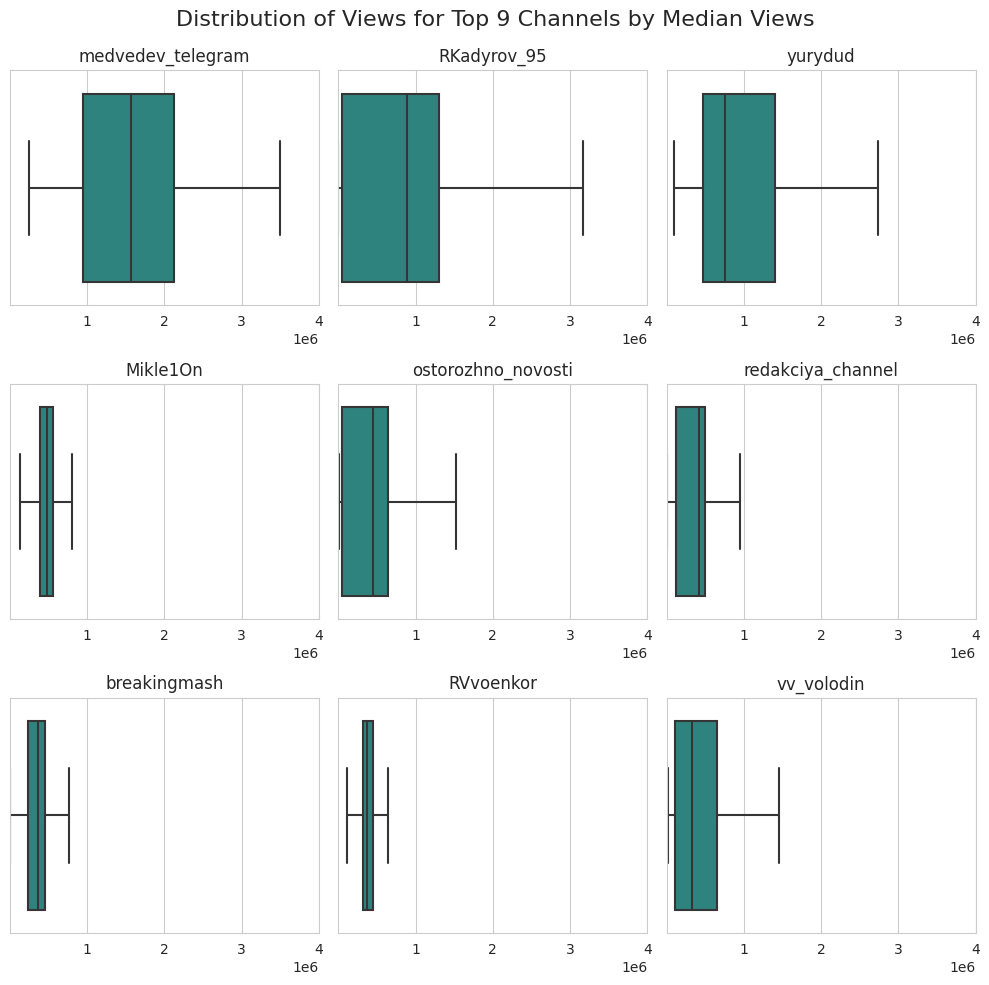

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Determine the global min and max views across all channels
global_min = views_df[views_df['channel'].isin(top_median_views_channels)]['views'].min()
global_max = 4000000.0

# Plotting for Top Median Views Channels
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Distribution of Views for Top 9 Channels by Median Views', fontsize=16)

for i, channel in enumerate(top_median_views_channels):
    ax = axes[i//3, i%3]
    sns.boxplot(data=views_df[views_df['channel'] == channel], x='views', ax=ax, palette="viridis", showfliers=False)
    ax.set_title(channel)
    ax.set_xlabel('')
    if i%3 != 0:
        ax.set_ylabel('')
    ax.set_xlim(global_min, global_max)  # Set the same scale for all subplots

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

- Distributions of popular channels moslty right skewed.


### What is the distribution of views in the biggest channels?

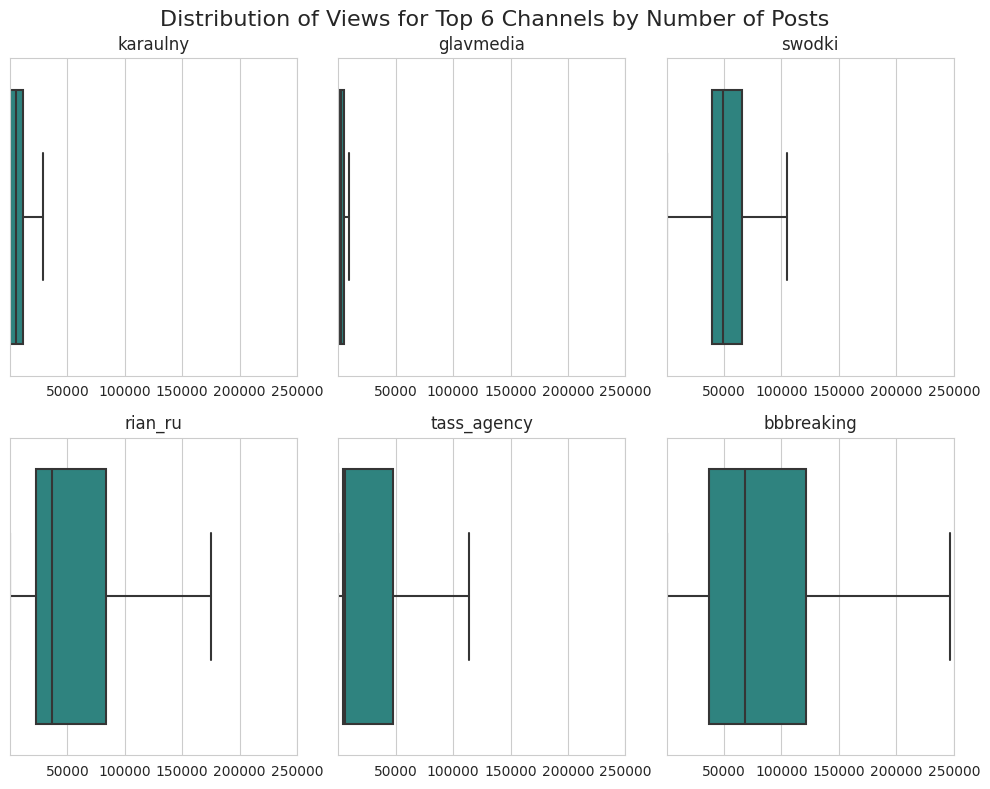

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming views_df is your DataFrame and top_posts_channels is a list of top 6 channels

# Determine the global min and max views across all channels
global_min = 1
global_max = 250000.0

# Plotting for Top Median Views Channels
fig, axes = plt.subplots(2, 3, figsize=(10, 8))  # Adjusted to a 2x3 grid
fig.suptitle('Distribution of Views for Top 6 Channels by Number of Posts', fontsize=16)

# Ensure that the list has exactly 6 channels
top_posts_channels = top_posts_channels[:6]

for i, channel in enumerate(top_posts_channels):
    row = i // 3  # Row index
    col = i % 3   # Column index
    ax = axes[row, col]
    sns.boxplot(data=views_df[views_df['channel'] == channel], x='views', ax=ax, palette="viridis", showfliers=False)
    ax.set_title(channel)
    ax.set_xlabel('')
    if col != 0:
        ax.set_ylabel('')
    ax.set_xlim(global_min, global_max)  # Set the same scale for all subplots

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


- The distributions of views in most posts' written number channels are also right-skewed.
- A lot of posts don't mean a lot of views. A lot of posts can be annoying. But again this is assumption, and better test it.

### What is the distribution of views across all posts in all channel?

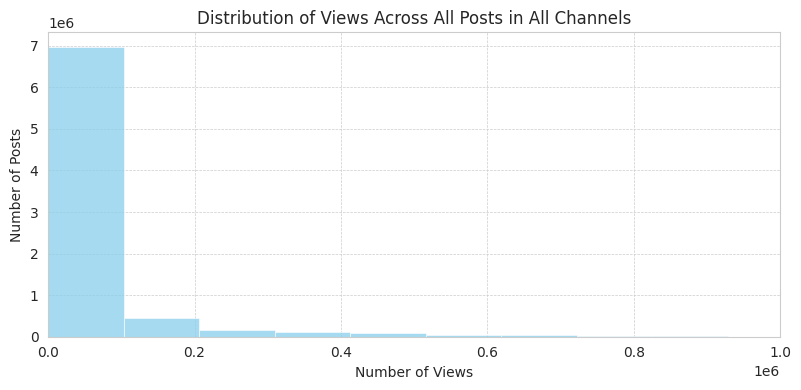

In [ ]:
plt.figure(figsize=(8, 4))

# Plotting the histogram
sns.histplot(views_df['views'], bins=100, kde=False, color='skyblue')

# Calculating quartiles and average
q1 = views_df['views'].quantile(0.25)
q2 = views_df['views'].quantile(0.5)
q3 = views_df['views'].quantile(0.75)
avg = views_df['views'].mean()

plt.title('Distribution of Views Across All Posts in All Channels')
plt.xlabel('Number of Views')
plt.ylabel('Number of Posts')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.xlim(0,1000000)  # Set the same scale for all subplots
plt.show()

- The distributions of views for all channels are right-skewed.
- So, the number of most viewed posts is much fewer than regular posts, which is obvious.

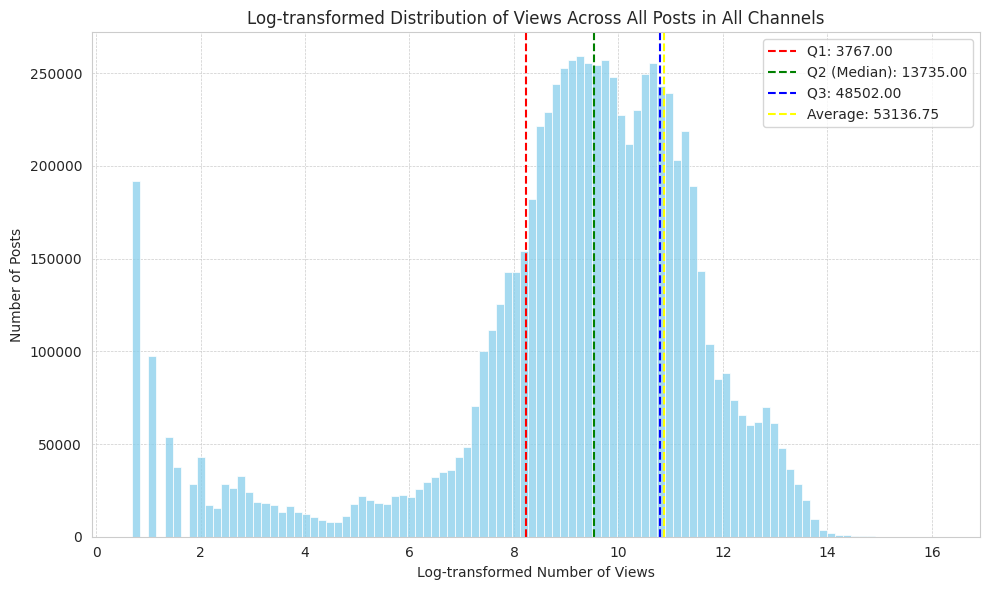

In [ ]:
plt.figure(figsize=(10, 6))

# Applying a log transformation to the views and adding 1 to handle any potential 0 values
views_log = np.log1p(views_df['views'])

# Plotting the histogram for the log-transformed views
sns.histplot(views_log, bins=100, kde=False, color='skyblue')

# Calculating quartiles and average for the log-transformed views
q1_log = np.log1p(views_df['views'].quantile(0.25))
q2_log = np.log1p(views_df['views'].quantile(0.5))
q3_log = np.log1p(views_df['views'].quantile(0.75))
avg_log = np.log1p(views_df['views'].mean())

# Annotating the quartiles and average
plt.axvline(q1_log, color='red', linestyle='--', label=f'Q1: {np.expm1(q1_log):.2f}')
plt.axvline(q2_log, color='green', linestyle='--', label=f'Q2 (Median): {np.expm1(q2_log):.2f}')
plt.axvline(q3_log, color='blue', linestyle='--', label=f'Q3: {np.expm1(q3_log):.2f}')
plt.axvline(avg_log, color='yellow', linestyle='--', label=f'Average: {np.expm1(avg_log):.2f}')

plt.title('Log-transformed Distribution of Views Across All Posts in All Channels')
plt.xlabel('Log-transformed Number of Views')
plt.ylabel('Number of Posts')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


- Log-transformed Distribution of Views is less skewed. It's not normal, but it can be a valuable feature for ML models. (Cause they better deal with normal distribution)

### Which channels have the most forwarded content?

In [ ]:
# Placeholder for storing forwarded counts for each channel
forwarded_counts = {}

# Loop through each channel and count forwarded messages
for channel in channel_names:
    try:
        df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")

        # Check if 'fwd_from' column exists in the DataFrame
        if 'fwd_from' not in df.columns:
            print(f"Column 'fwd_from' not found in {channel}. Skipping to the next file.")
            continue

        # Count the number of forwarded messages
        forwarded_count = df[pd.notnull(df['fwd_from'])].shape[0]
        forwarded_counts[channel] = forwarded_count

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue



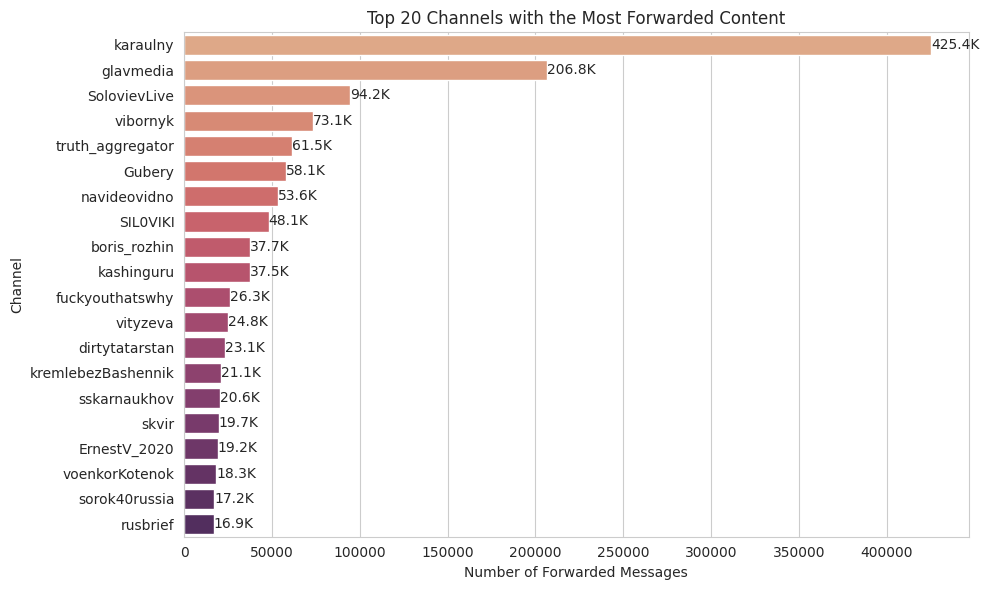

In [ ]:
# Convert the dictionary to a DataFrame and sort by forwarded count
forwarded_df = pd.DataFrame(list(forwarded_counts.items()), columns=['channel', 'forwarded_count'])
forwarded_df = forwarded_df.sort_values(by='forwarded_count', ascending=False).head(20)

# Plotting using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='forwarded_count', y='channel', data=forwarded_df, palette='flare')
plt.xlabel('Number of Forwarded Messages')
plt.ylabel('Channel')
plt.title('Top 20 Channels with the Most Forwarded Content')

# Function to format the number with 'K' for thousands
def format_number(num):
    if num >= 1000:
        return f'{num/1000:.1f}K'
    else:
        return str(num)

# Annotate each bar with its respective value
for p in ax.patches:
    width = p.get_width()
    formatted_width = format_number(width)
    ax.text(width + 5,  # set the text at 5 unit right of the bar
            p.get_y() + p.get_height() / 2,  # get Y coordinate + X coordinate / 2
            formatted_width,  # formatted value
            ha="left",  # horizontal alignment
            va="center")  # vertical alignment

plt.tight_layout()
plt.show()

- In this top, we can see a lot of channels from the Top 20 Channels by Number of Posts. So, a large number of posts are collected due to reposted posts.

### Which channels are the most common sources of forwarded content?

In [ ]:
# Placeholder for storing sources of forwarded content
forwarded_sources = {}

# Loop through each channel and count the sources of forwarded messages
for channel in channel_names:
    try:
        df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")

        # Check if 'frw_from_name' column exists in the DataFrame
        if 'frw_from_name' not in df.columns:
            print(f"Column 'frw_from_name' not found in {channel}. Skipping to the next file.")
            continue

        # Count the occurrences of each source
        source_counts = df['frw_from_name'].value_counts().to_dict()
        for source, count in source_counts.items():
            if source in forwarded_sources:
                forwarded_sources[source] += count
            else:
                forwarded_sources[source] = count

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue

# Convert the dictionary to a DataFrame and sort by count
sources_df = pd.DataFrame(list(forwarded_sources.items()), columns=['channel', 'count'])
sources_df = sources_df.sort_values(by='count', ascending=False).head(20)  # Get top 20 sources



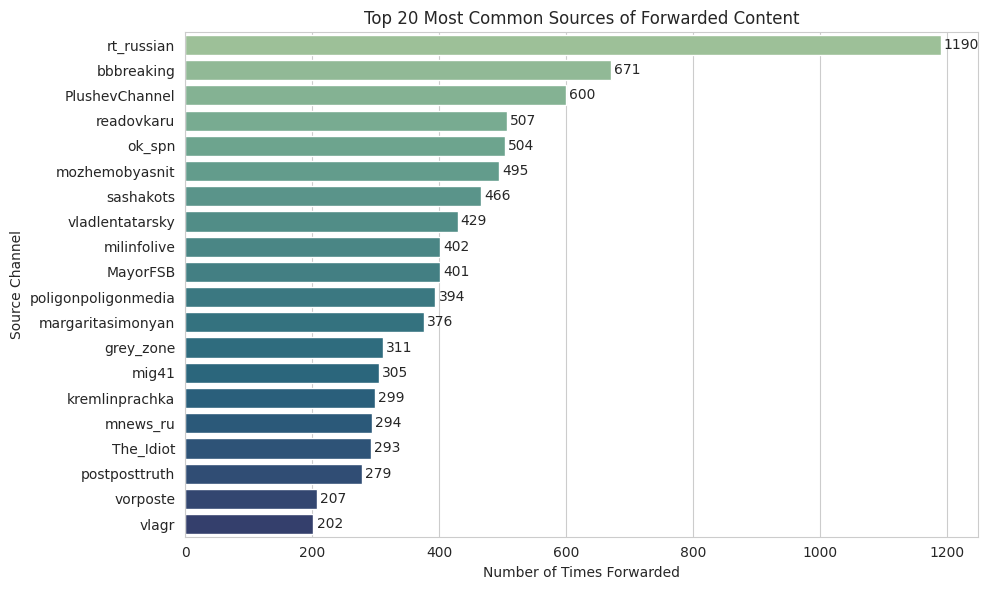

In [ ]:
# Plotting using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='count', y='channel', data=sources_df, palette='crest')
plt.xlabel('Number of Times Forwarded')
plt.ylabel('Source Channel')
plt.title('Top 20 Most Common Sources of Forwarded Content')

# Annotate each bar with its respective value
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 5,  # set the text at 5 unit right of the bar
            p.get_y() + p.get_height() / 2,  # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width),  # set variable to display, 2 decimals
            ha="left",  # horizontal alignment
            va="center")  # vertical alignment

plt.tight_layout()
plt.show()


- From this top, we can see that "Sources of Forwarded Content" channels are coming from russian military correspondents.

## **Reactions Analysis**

### Which channels gather the biggest number of reactions?

In [ ]:
# Placeholder for the data
reactions_data = []

# Regular expression pattern to extract counts
pattern = r"count=(\d+)"

# Loop through each channel and aggregate reactions
for channel in channel_names:
    try:
        df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")

        # Check if 'reactions' column exists in the DataFrame
        if 'reactions' not in df.columns:
            print(f"Column 'reactions' not found in {channel}. Skipping to the next file.")
            continue

        # Extract total reactions for each post
        df['total_reactions'] = df['reactions'].apply(lambda x: sum([int(count) for count in re.findall(pattern, str(x))]))

        # Append to the reactions_data list
        temp_df = df[['total_reactions']].copy()
        temp_df['channel'] = channel
        reactions_data.append(temp_df)

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue

# Concatenate all dataframes
reactions_df = pd.concat(reactions_data, ignore_index=True)

# Aggregate total reactions by channel
channel_reactions = reactions_df.groupby('channel').sum().reset_index()


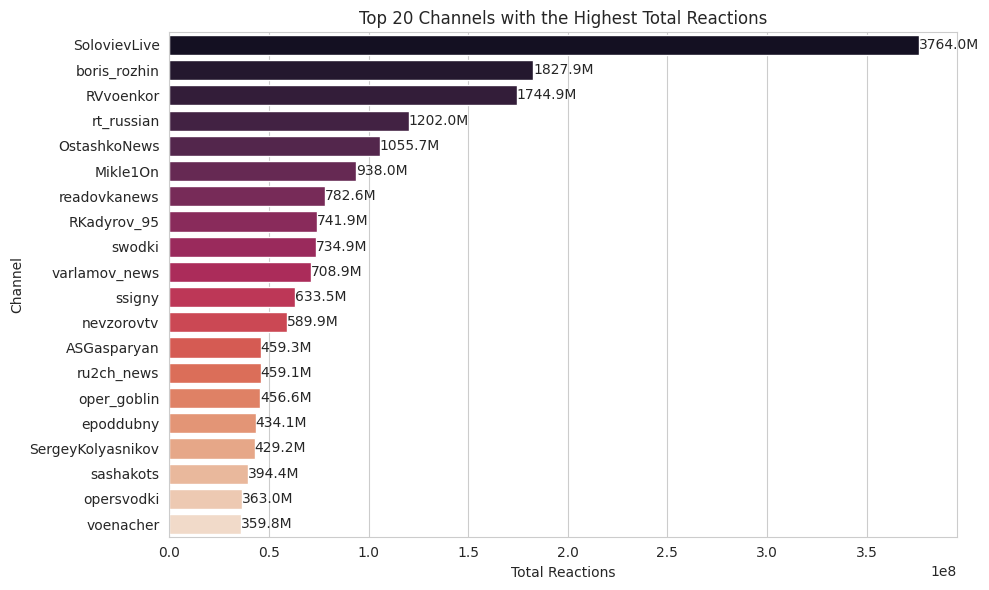

In [ ]:
# Plotting the top 20 channels with the highest total reactions
plt.figure(figsize=(10, 6))
top_channels = channel_reactions.nlargest(20, 'total_reactions')
ax = sns.barplot(data=top_channels, y='channel', x='total_reactions', palette="rocket")

# Function to format the number with 'K' for thousands
def format_number(num):
    if num >= 100000:
        return f'{num/100000:.1f}M'
    else:
        return str(num)

# Annotate each bar with its respective value
for p in ax.patches:
    width = p.get_width()
    formatted_width = format_number(width)
    ax.text(width + 5,  # set the text at 5 unit right of the bar
            p.get_y() + p.get_height() / 2,  # get Y coordinate + X coordinate / 2
            formatted_width,  # formatted value
            ha="left",  # horizontal alignment
            va="center")  # vertical alignment
plt.title('Top 20 Channels with the Highest Total Reactions')
plt.xlabel('Total Reactions')
plt.ylabel('Channel')
plt.tight_layout()
plt.show()


- Channels with the most reactions belong to politicians, military correspondents, and bloggers.

### What are the most common reactions across all channels?


In [ ]:
from collections import defaultdict

# Placeholder for all reactions
reactions_counter = defaultdict(int)

# Regular expression pattern to extract reactions and their counts
pattern = r"reaction='(.*?)'.*?count=(\d+)"

# Loop through each channel and aggregate reactions
for channel in channel_names:
    try:
        df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")

        # Check if 'reactions' column exists in the DataFrame
        if 'reactions' not in df.columns:
            print(f"Column 'reactions' not found in {channel}. Skipping to the next file.")
            continue

        # Extract reactions and update the counter
        for reaction_str in df['reactions'].dropna():
            reactions_list = re.findall(pattern, reaction_str)
            for reaction, count in reactions_list:
                reactions_counter[reaction] += int(count)

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue

# Convert the reactions counter to a DataFrame
reactions_df = pd.DataFrame(list(reactions_counter.items()), columns=['Reaction', 'Frequency'])



In [ ]:
import plotly.graph_objects as go

top_reactions = reactions_df.nlargest(20, 'Frequency')
# Function to format the numbers
def format_number(num):
    if num >= 1000000:
        return f"{num/1000000:.1f}M"
    elif num >= 1000:
        return f"{num/1000:.1f}K"
    else:
        return str(num)

# Sorting the data in descending order
top_reactions = top_reactions.sort_values(by='Frequency', ascending=True)

# Create the bar chart
fig = go.Figure(go.Bar(
    x=top_reactions['Frequency'],
    y=top_reactions['Reaction'],
    orientation='h',
    text=[format_number(val) for val in top_reactions['Frequency']],
    textposition='outside',
    marker_color=top_reactions['Frequency'],
    marker_colorscale='agsunset'
))

# Update layout
fig.update_layout(
    title='Top 20 Most Common Reactions Across All Channels',
    xaxis_title='Frequency',
    yaxis_title='Reaction',
    showlegend=False
)

fig.show()


- russians like propaganda. Positive reactions prevail over negative ones.
- Negative reactions can come from events where Russia suffered losses. (we will see in the time series analysis)

### Which posts receive the most positive reactions vs. negative reactions?

In [ ]:
positive_reactions = ['👍', '🔥','❤\u200d🔥', '👏', '🤣', '🥰', '😁', '❤','🎉']
negative_reactions = ['👎', '🤬', '💩', '🤮', '🤡','😢','😱']


In [ ]:
# Placeholder for the data
posts_data = []

# Regular expression pattern to extract reactions and counts
pattern = r"reaction='(.*?)', count=(\d+)"

# Loop through each channel and aggregate reactions
for channel in channel_names:
    try:
        df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")

        # Check if 'reactions' column exists in the DataFrame
        if 'reactions' not in df.columns:
            print(f"Column 'reactions' not found in {channel}. Skipping to the next file.")
            continue

        # Extract reactions and their counts for each post
        df['reactions_dict'] = df['reactions'].apply(lambda x: {match[0]: int(match[1]) for match in re.findall(pattern, str(x))})

        # Calculate total positive and negative reactions for each post
        df['positive_reactions'] = df['reactions_dict'].apply(lambda x: sum([x[emoji] for emoji in positive_reactions if emoji in x]))
        df['negative_reactions'] = df['reactions_dict'].apply(lambda x: sum([x[emoji] for emoji in negative_reactions if emoji in x]))

        # Append to the posts_data list
        temp_df = df[['message', 'positive_reactions', 'negative_reactions']].copy()
        temp_df['channel'] = channel
        posts_data.append(temp_df)

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue

# Concatenate all dataframes
posts_df = pd.concat(posts_data, ignore_index=True)

# Identify the posts with the highest positive and negative reactions
top_positive_posts = posts_df.nlargest(25, 'positive_reactions')
top_negative_posts = posts_df.nlargest(25, 'negative_reactions')


In [ ]:
top_positive_posts = posts_df.nlargest(15, 'positive_reactions')
top_negative_posts = posts_df.nlargest(15, 'negative_reactions')

In [ ]:
top_positive_posts = top_positive_posts.dropna(subset=['message'])
top_negative_posts = top_negative_posts.dropna(subset=['message'])


In [ ]:
import plotly.graph_objects as go

# Function to create a table visualization with adjustable height
def create_table(df, title, height=400):
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[df[column] for column in df.columns],
                   fill_color='lavender',
                   align='left'))
    ])
    fig.update_layout(title=title, height=height)
    fig.show()

# Assuming top_positive_posts and top_negative_posts are your DataFrames
# Adjust the height as needed to display more rows
create_table(top_positive_posts, "Top Posts with Positive Reactions", height=800)



In [ ]:
create_table(top_negative_posts, "Top Posts with Negative Reactions", height=800)

- kadyrov has posts with the most positive reactions:
  - Posts with the most positive reactions related to criticism of military decisions that lead to losses of occupied territories.
  - Criticism of so-called "russian liberals".
  - Criticism of captives exchange (Azov from our side).
  - The post where he approved that our cities were bombed have a lot of positive reactions.
  - Posts at the beginning of the war where russians were so proud of themselves to start the war have a lot of positive reactions.


- nevzorov has posts with the most negative reactions.
  - his posts are mostly about criticism of putin, russian propagandists, and russian army in some ways (He tries to avoid responsibility for all russians, like it's just putin and his army).
  - his post about Ukrainian citizenship has a close number of positive and negative reactions (negative prevails). This post is in both tops. My assumption: a lot of positive reactions come from so-called liberal russians as a sign that responsibility can be avoided.

### How do reactions correlate with the number of views?


<ipython-input-5-6784f0fc8429>:10: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")
<ipython-input-5-6784f0fc8429>:10: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")
<ipython-input-5-6784f0fc8429>:10: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")
<ipython-input-5-6784f0fc8429>:10: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")


Columns 'reactions' or 'views' not found in rybar. Skipping to the next file.


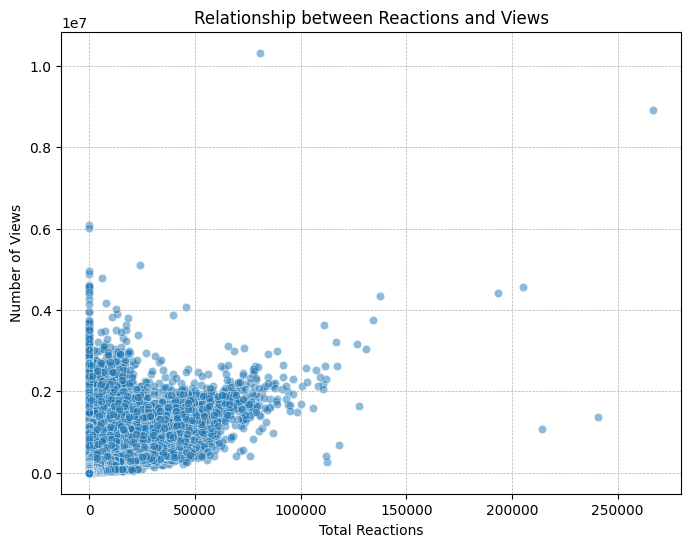

In [ ]:
# Placeholder for the data
all_data = []

# Regular expression pattern to extract counts
pattern = r"count=(\d+)"

# Loop through each channel and aggregate reactions and views
for channel in channel_names:
    try:
        df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")

        # Check if 'reactions' and 'views' columns exist in the DataFrame
        if 'reactions' not in df.columns or 'views' not in df.columns:
            print(f"Columns 'reactions' or 'views' not found in {channel}. Skipping to the next file.")
            continue

        # Extract total reactions for each post
        df['total_reactions'] = df['reactions'].apply(lambda x: sum([int(count) for count in re.findall(pattern, str(x))]))

        # Append to the all_data list
        all_data.append(df[['total_reactions', 'views']])

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue

# Concatenate all dataframes
df_corr = pd.concat(all_data, ignore_index=True)

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_corr, x='total_reactions', y='views', alpha=0.5)
plt.title('Relationship between Reactions and Views')
plt.xlabel('Total Reactions')
plt.ylabel('Number of Views')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [ ]:

correlation_coefficient = df_corr['total_reactions'].corr(df_corr['views'], method='pearson')
print(f"Pearson Correlation Coefficient between Reactions and Views: {correlation_coefficient:.2f}")

correlation_coefficient = df_corr['total_reactions'].corr(df_corr['views'], method='spearman')
print(f"Spearman  Correlation Coefficient between Reactions and Views: {correlation_coefficient:.2f}")

Pearson Correlation Coefficient between Reactions and Views: 0.44
Spearman  Correlation Coefficient between Reactions and Views: 0.33


- We don't see a solid linear dependency between reactions and views on the figure. Correlation coefficients are accordingly low.
- As we can see, the correlation between reactions and the number of views is not significant for sample with all channels.

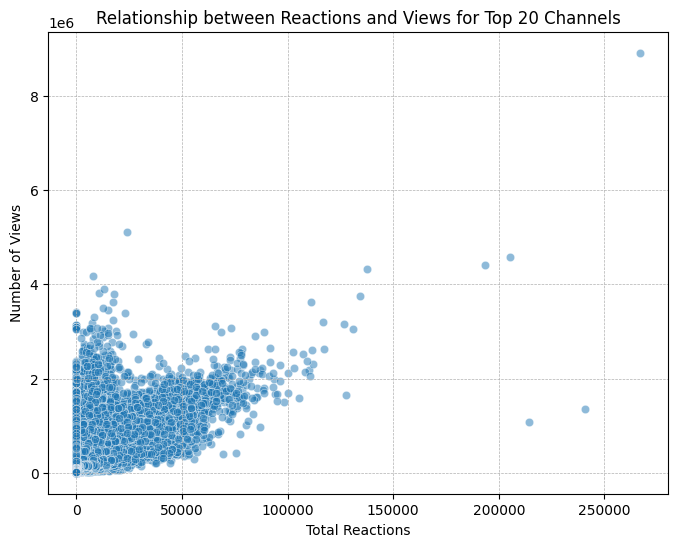

In [ ]:
# Get the top 20 channels based on total reactions
top_20_channels = channel_reactions.nlargest(20, 'total_reactions')['channel'].tolist()

# Placeholder for the data of top 20 channels
top_channels_data = []

# Loop through each of the top 20 channels and aggregate reactions and views
for channel in top_20_channels:
    try:
        df_channel = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")

        # Check if 'reactions' and 'views' columns exist in the DataFrame
        if 'reactions' not in df_channel.columns or 'views' not in df_channel.columns:
            print(f"Columns 'reactions' or 'views' not found in {channel}. Skipping to the next file.")
            continue

        # Extract total reactions for each post
        df_channel['total_reactions'] = df_channel['reactions'].apply(lambda x: sum([int(count) for count in re.findall(pattern, str(x))]))

        # Append to the top_channels_data list
        top_channels_data.append(df_channel[['total_reactions', 'views']])

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue

# Concatenate all dataframes of top 20 channels
df_top_channels = pd.concat(top_channels_data, ignore_index=True)


# Scatter plot for top 20 channels
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_top_channels, x='total_reactions', y='views', alpha=0.5)
plt.title('Relationship between Reactions and Views for Top 20 Channels')
plt.xlabel('Total Reactions')
plt.ylabel('Number of Views')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [ ]:
# Calculate the correlation coefficient for top 20 channels
correlation_coefficient_top = df_top_channels['total_reactions'].corr(df_top_channels['views'], method='spearman')
print(f"Spearman Correlation Coefficient between Reactions and Views for Top 20 Channels: {correlation_coefficient_top:.2f}")

# Calculate the correlation coefficient for top 20 channels
correlation_coefficient_top = df_top_channels['total_reactions'].corr(df_top_channels['views'], method='pearson')
print(f"Pearson Correlation Coefficient between Reactions and Views for Top 20 Channels: {correlation_coefficient_top:.2f}")


Spearman Correlation Coefficient between Reactions and Views for Top 20 Channels: 0.63
Pearson Correlation Coefficient between Reactions and Views for Top 20 Channels: 0.66


- For top popular channels, the correlation is higher but not substantial.


### Do posts with videos or photos receive more reactions than text-only posts?

In [ ]:
from scipy.stats import ttest_ind

# Placeholder for the data
posts_data = []

# Regular expression pattern to extract reactions and their counts
pattern = r"reaction='(.*?)', count=(\d+)"

# Loop through each of the top 20 channels and aggregate reactions
for channel in channel_names:
    try:
        df_channel = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")

        # Check if 'reactions' column exists in the DataFrame
        if 'reactions' not in df_channel.columns:
            print(f"Column 'reactions' not found in {channel}. Skipping to the next file.")
            continue

        # Append to the posts_data list
        temp_df = df_channel[['type', 'reactions']].copy()
        posts_data.append(temp_df)

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue

# Concatenate all dataframes
df_hypothesis = pd.concat(posts_data, ignore_index=True)


In [ ]:
# Extract total positive reactions for each post
df_hypothesis['positive_reactions'] = df_hypothesis['reactions'].apply(lambda x: sum([int(count) for emoji in positive_reactions for count in re.findall(f"reaction='{emoji}', count=(\d+)", str(x))]))
df_hypothesis['negative_reactions'] = df_hypothesis['reactions'].apply(lambda x: sum([int(count) for emoji in negative_reactions for count in re.findall(f"reaction='{emoji}', count=(\d+)", str(x))]))


#### Do posts with videos or photos receive more positive reactions than text-only posts?

In [ ]:
# Categorizing posts into two groups
media_posts = df_hypothesis[df_hypothesis['type'].isin(['video', 'photo'])]['positive_reactions']
text_posts = df_hypothesis[df_hypothesis['type'] == 'text']['positive_reactions']

# Performing the t-test
t_stat, p_value = ttest_ind(media_posts, text_posts, equal_var=False, nan_policy='omit')

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpreting the results
alpha = 0.05
if p_value < alpha:
    print("We reject the null hypothesis. There is a significant difference in the number of positive reactions between posts with videos/photos and text-only posts.")
else:
    print("We fail to reject the null hypothesis. There is no significant difference in the number of positive reactions between posts with videos/photos and text-only posts.")

T-statistic: 77.51443529955284
P-value: 0.0
We reject the null hypothesis. There is a significant difference in the number of positive reactions between posts with videos/photos and text-only posts.


#### Do posts with videos or photos receive more negative reactions than text-only posts?

In [ ]:
# Categorizing posts into two groups
media_posts_n = df_hypothesis[df_hypothesis['type'].isin(['video', 'photo'])]['negative_reactions']
text_posts_n = df_hypothesis[df_hypothesis['type'] == 'text']['negative_reactions']

# Performing the t-test
t_stat, p_value = ttest_ind(media_posts_n, text_posts_n, equal_var=False, nan_policy='omit')

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpreting the results
alpha = 0.05
if p_value < alpha:
    print("We reject the null hypothesis. There is a significant difference in the number of negative reactions between posts with videos/photos and text-only posts.")
else:
    print("We fail to reject the null hypothesis. There is no significant difference in the number of negative reactions between posts with videos/photos and text-only posts.")

T-statistic: 39.88288243963271
P-value: 0.0
We reject the null hypothesis. There is a significant difference in the number of negative reactions between posts with videos/photos and text-only posts.


- As we can see in both cases there is a significant difference in the number of positive|negative reactions between posts with videos/photos and text-only posts.

## **Content Analysis**

###  What are the most frequently used words across all channels?

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-10-ef6ecd3e3077>:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")
<ipython-input-10-ef6ecd3e3077>:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")
<ipython-input-10-ef6ecd3e3077>:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")
<ipython-input-10-ef6ecd3e3077>:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{chan

Column 'message' not found in rybar. Skipping to the next file.


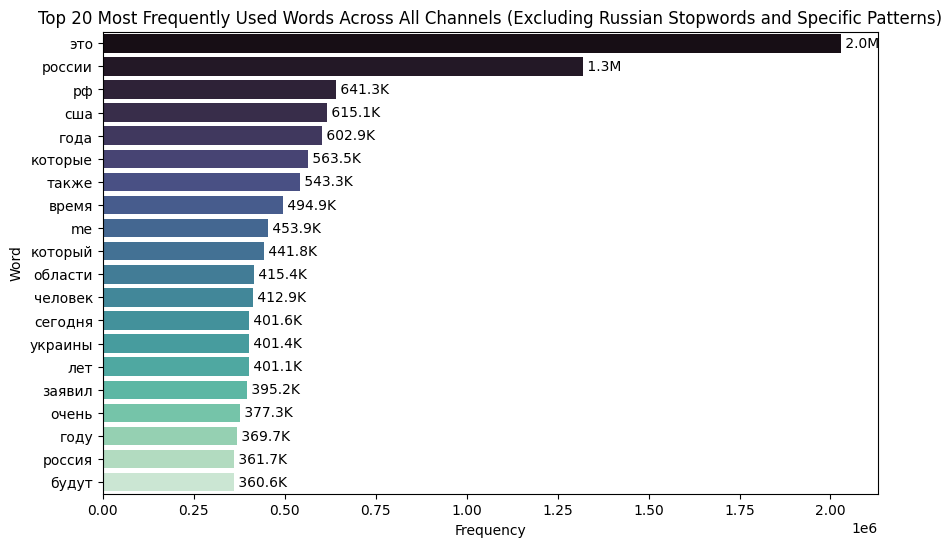

In [ ]:
# Download Russian stopwords
nltk.download('stopwords')
russian_stopwords = set(stopwords.words("russian"))

# Additional words and patterns to exclude
exclude_patterns = [r'\d+', 't', 'ru', 'https']

# Placeholder for word frequencies
word_freq = Counter()

# Loop through each channel and aggregate word frequencies
for channel in channel_names:
    try:
        df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")

        # Check if 'message' column exists in the DataFrame
        if 'message' not in df.columns:
            print(f"Column 'message' not found in {channel}. Skipping to the next file.")
            continue

        # Tokenize the text, remove stopwords, and update word frequencies
        for message in df['message'].dropna():
            words = [word for word in re.findall(r'\w+', message.lower()) if word not in russian_stopwords and not any(re.match(pattern, word) for pattern in exclude_patterns)]  # Convert to lowercase, tokenize, and filter out stopwords and excluded patterns
            word_freq.update(words)

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue

# Extracting top 20 most common words
top_words = word_freq.most_common(20)

# Format number function
def format_number(num):
    if num >= 1000000:
        return f"{num/1000000:.1f}M"
    elif num >= 1000:
        return f"{num/1000:.1f}K"
    else:
        return str(num)

# Plotting the top words
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=[count for word, count in top_words], y=[word for word, count in top_words], palette="mako")

# Adding the frequency number to each bar
for index, value in enumerate([count for word, count in top_words]):
    ax.text(value, index, f' {format_number(value)}', color='black', ha="left", va="center")

plt.title('Top 20 Most Frequently Used Words Across All Channels (Excluding Russian Stopwords and Specific Patterns)')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


Assumptions:
- Propagandists talk a lot about russia, obviously
- They blame the USA for all negative things
- They perceive Ukraine as an object, not a subject.

### What are the most common bigrams across top popular channels?
(I don't have enough computing power to find the most common bigrams across all channels, so I reduced the sample.)

In [ ]:
from nltk.util import ngrams
import gc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


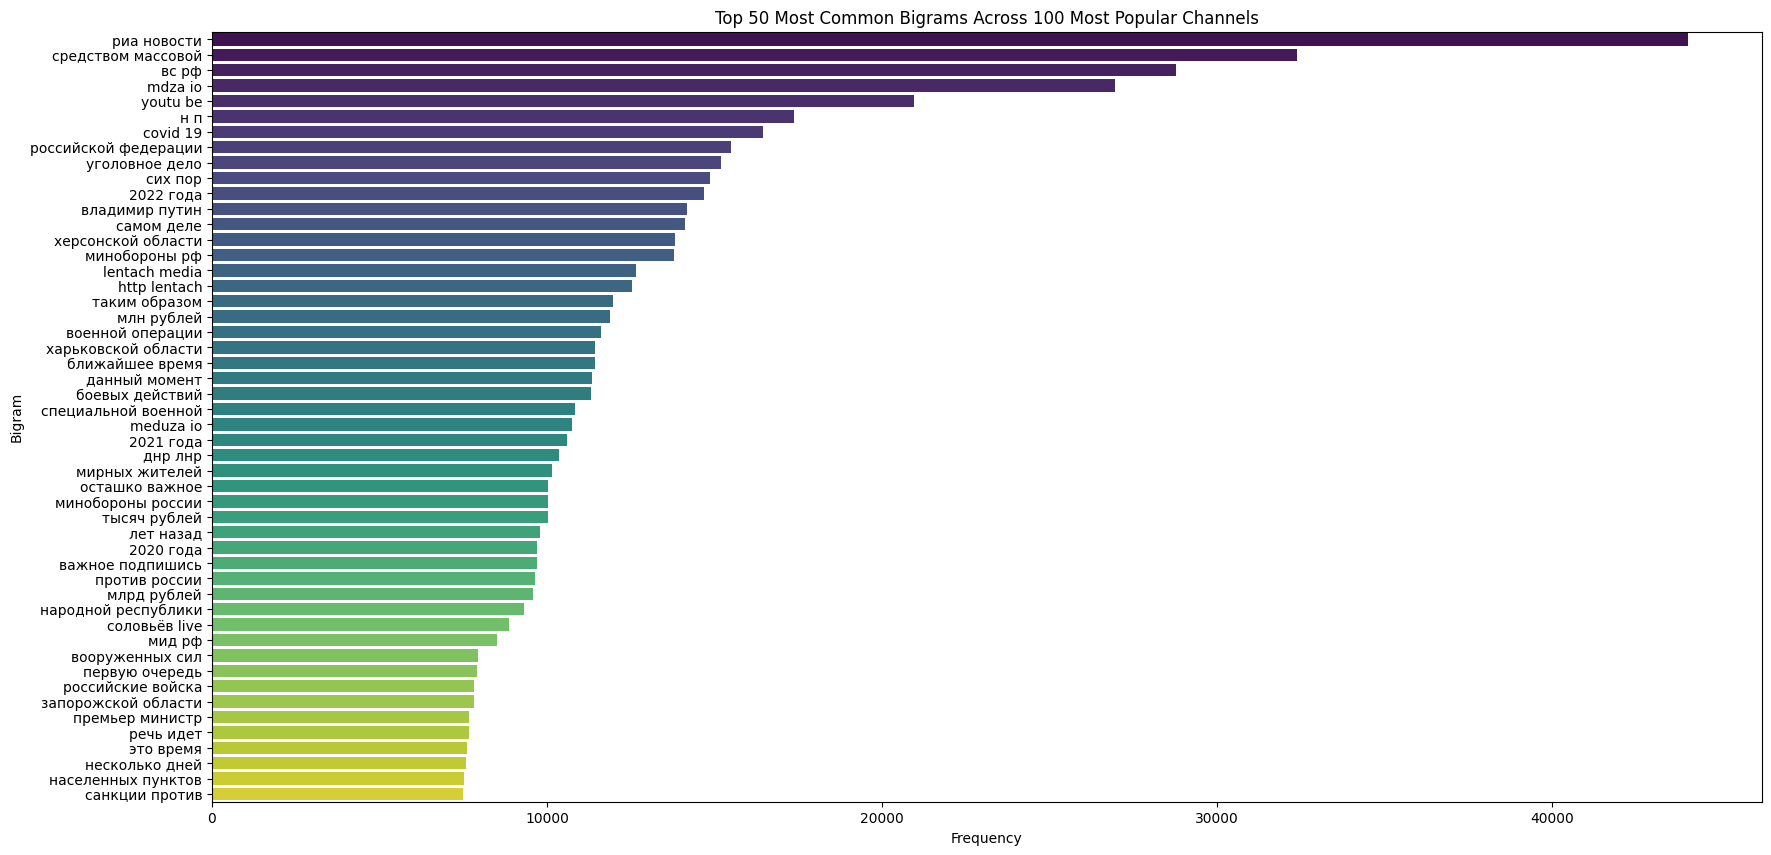

13706

In [ ]:
# Download Russian stopwords
nltk.download('stopwords')
russian_stopwords = set(stopwords.words("russian"))

# Placeholder for bigram frequencies using a default dictionary
bigram_freq = defaultdict(int)

# custom stop words
custom_stopwords = ['t', 'me', 'ru', 'https','1','2','5']

# Extend the NLTK's stop words list with custom words
russian_stopwords.update(custom_stopwords)

# custom bigram stop words
custom_bigram_stopwords = [('иностранного', 'агента'), ('функции', 'иностранного'),
                           ('выполняющим', 'функции'),('массовой', 'информации'),
                           ('данное', 'сообщение'), ('лицом', 'выполняющим'),
                           ('юридическим', 'лицом'),('cредством','массовой'),
                           ('сообщение', 'материал'),('материал', 'создано'),
                           ('создано', 'распространено'),('иностранным', 'средством'),
                           ('российским', 'юридическим'),('информации', 'выполняющим'),
                           ('агента', 'российским'),('распространено','иностранным')]

# Define a smaller chunk size
chunk_size = 1000
top_median_views = aggregated_df.nlargest(100, 'median_views')

# Loop through each channel and aggregate bigram frequencies
for channel in top_median_views['channel']:
    try:
        # Read the CSV in chunks and only the 'message' column
        for chunk in pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv", usecols=['message'], chunksize=chunk_size):

            # Tokenize each message individually, remove stopwords, and update bigram frequencies
            for message in chunk['message'].dropna():
                words = [word for word in re.findall(r'\w+', message.lower()) if word not in russian_stopwords]
                for bigram in ngrams(words, 2):
                    if bigram not in custom_bigram_stopwords:
                        bigram_freq[bigram] += 1

            # delete the chunk and collect garbage
            del chunk
            gc.collect()

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue

# Extracting top 20 most common bigrams
top_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)[:50]

# Plotting top bigrams
plt.figure(figsize=(20, 10))
sns.barplot(x=[count for bigram, count in top_bigrams], y=[' '.join(bigram) for bigram, count in top_bigrams], palette="viridis")
plt.title('Top 50 Most Common Bigrams Across 100 Most Popular Channels')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()

# Clear the bigram_freq to free up memory
del bigram_freq
gc.collect()


A lot of bigrams with media names (ideally need to be cleaned)

Common topics:
- russia
- putin (ehat he said or what he did)
- occupied Ukrainian territories
- russian ministry of defense
- criminal case (don't know how to interpret it, context is needed)
- so-called "CBO" (russians way to call war)
- civilian people (I assume they blame Ukraine for all civilian people's deaths)
- all Western world against russia narrative
- money
- a lot of timeframes (don't know how to interpret it)

### What bigrams have the highest TF-IDF scores?
(reflects how statistically significant a bigram is to the corpus)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cредством', 'агента', 'выполняющим', 'данное', 'иностранного', 'иностранным', 'информации', 'лицом', 'массовой', 'материал', 'распространено', 'российским', 'создано', 'сообщение', 'средством', 'функции', 'юридическим'] not in stop_words.
  warnings.warn(


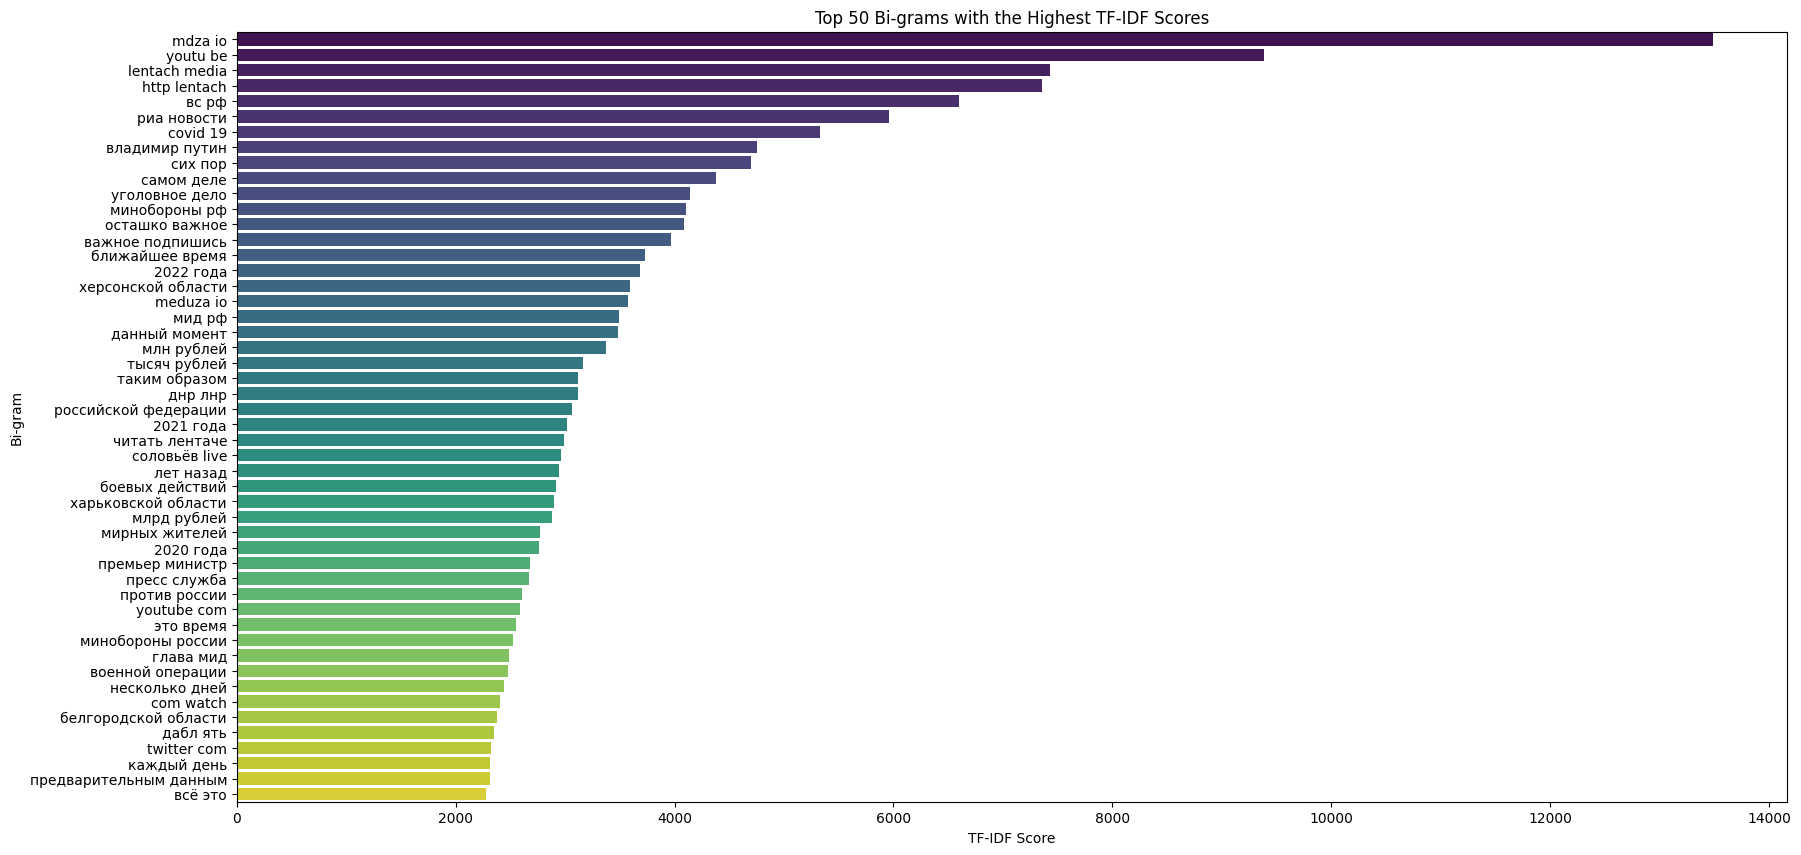

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Russian stopwords
nltk.download('stopwords')
russian_stopwords = set(stopwords.words("russian"))

# custom stop words
custom_stopwords = ['t', 'me', 'ru', 'https','иностранного', 'агента', 'функции',
                           'выполняющим', 'массовой', 'информации',
                           'данное', 'сообщение', 'лицом',
                           'юридическим', 'cредством', 'материал', 'создано',
                           'распространено','иностранным', 'средством'
]
russian_stopwords.update(custom_stopwords)

# Placeholder for all messages
all_messages = []

# Custom bigram stopwords
custom_bigram_stopwords = [('иностранного', 'агента'), ('функции', 'иностранного'),
                           ('выполняющим', 'функции'),('массовой', 'информации'),
                           ('данное', 'сообщение'), ('лицом', 'выполняющим'),
                           ('юридическим', 'лицом'),('cредством','массовой'),
                           ('сообщение', 'материал'),('материал', 'создано'),
                           ('создано', 'распространено'),('иностранным', 'средством'),
                           ('российским', 'юридическим'),('информации', 'выполняющим'),
                           ('агента', 'российским'),('распространено','иностранным')]

# Define a smaller chunk size
chunk_size = 1000
top_median_views = aggregated_df.nlargest(75, 'median_views')

# Loop through each channel and aggregate messages
for channel in top_median_views['channel']:
    try:
        # Read the CSV in chunks and only the 'message' column
        for chunk in pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv", usecols=['message'], chunksize=chunk_size):
            for message in chunk['message'].dropna():
                words = [word for word in re.findall(r'\w+', message.lower()) if word not in russian_stopwords]
                all_messages.append(' '.join(words))

            # delete the chunk and collect garbage
            del chunk
            gc.collect()

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue

# TF-IDF Vectorization for Bi-grams
vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=5000, stop_words=[' '.join(bigram) for bigram in custom_bigram_stopwords])
X = vectorizer.fit_transform(all_messages)
feature_names = vectorizer.get_feature_names_out()
sums = X.sum(axis=0)

# Create a dictionary of bi-grams and their corresponding TF-IDF scores
data = []
for col, term in enumerate(feature_names):
    data.append((term, sums[0, col]))

# Sort bi-grams by TF-IDF scores
ranking = pd.DataFrame(data, columns=['term', 'rank']).sort_values('rank', ascending=False)

# Plotting the top 50 bi-grams with the highest TF-IDF scores
plt.figure(figsize=(20, 10))
sns.barplot(x='rank', y='term', data=ranking.head(50), palette="viridis")
plt.title('Top 50 Bi-grams with the Highest TF-IDF Scores')
plt.xlabel('TF-IDF Score')
plt.ylabel('Bi-gram')
plt.show()


Againc, a lot of bigrams with media names (ideally need to be cleaned)

Common topics are simialr to Top 50 Most Common Bigrams Across, like
- russia
- putin (ehat he said or what he did)
- occupied Ukrainian territories
- russian ministry of defense
- money
- ...and so on.


### Which bigrams with the highest TF-IDF scores related to Ukraine or russia?

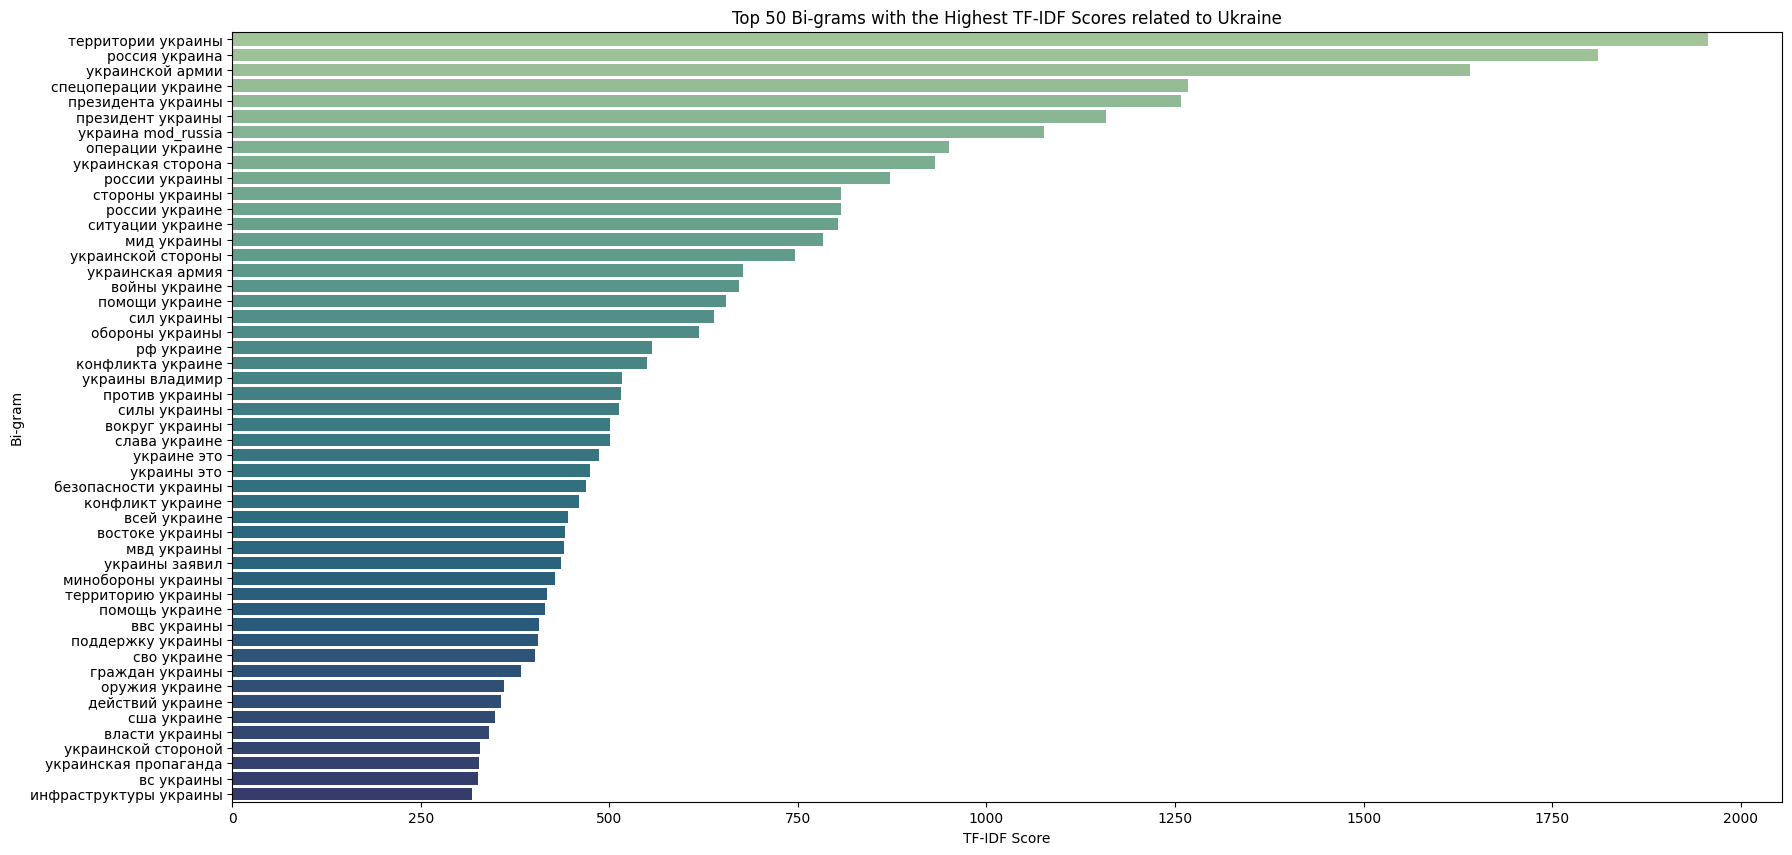

In [ ]:
# Filter bigrams for those containing 'украина', 'украине', 'украины'
ukraine_related_bigrams = ranking[ranking['term'].str.contains('украина|украине|украины|украинской|украинская', regex=True)]

# Plotting the top bigrams related to Ukraine
plt.figure(figsize=(20, 10))
sns.barplot(x='rank', y='term', data=ukraine_related_bigrams.head(50), palette="crest")
plt.title('Top 50 Bi-grams with the Highest TF-IDF Scores related to Ukraine')
plt.xlabel('TF-IDF Score')
plt.ylabel('Bi-gram')
plt.show()




Assumptions:
- They avoid calling the war a war. Used words to replace "war".
- They perceive Ukraine as an object, not a subject.
- They perceive Ukraine as the USA's puppet.

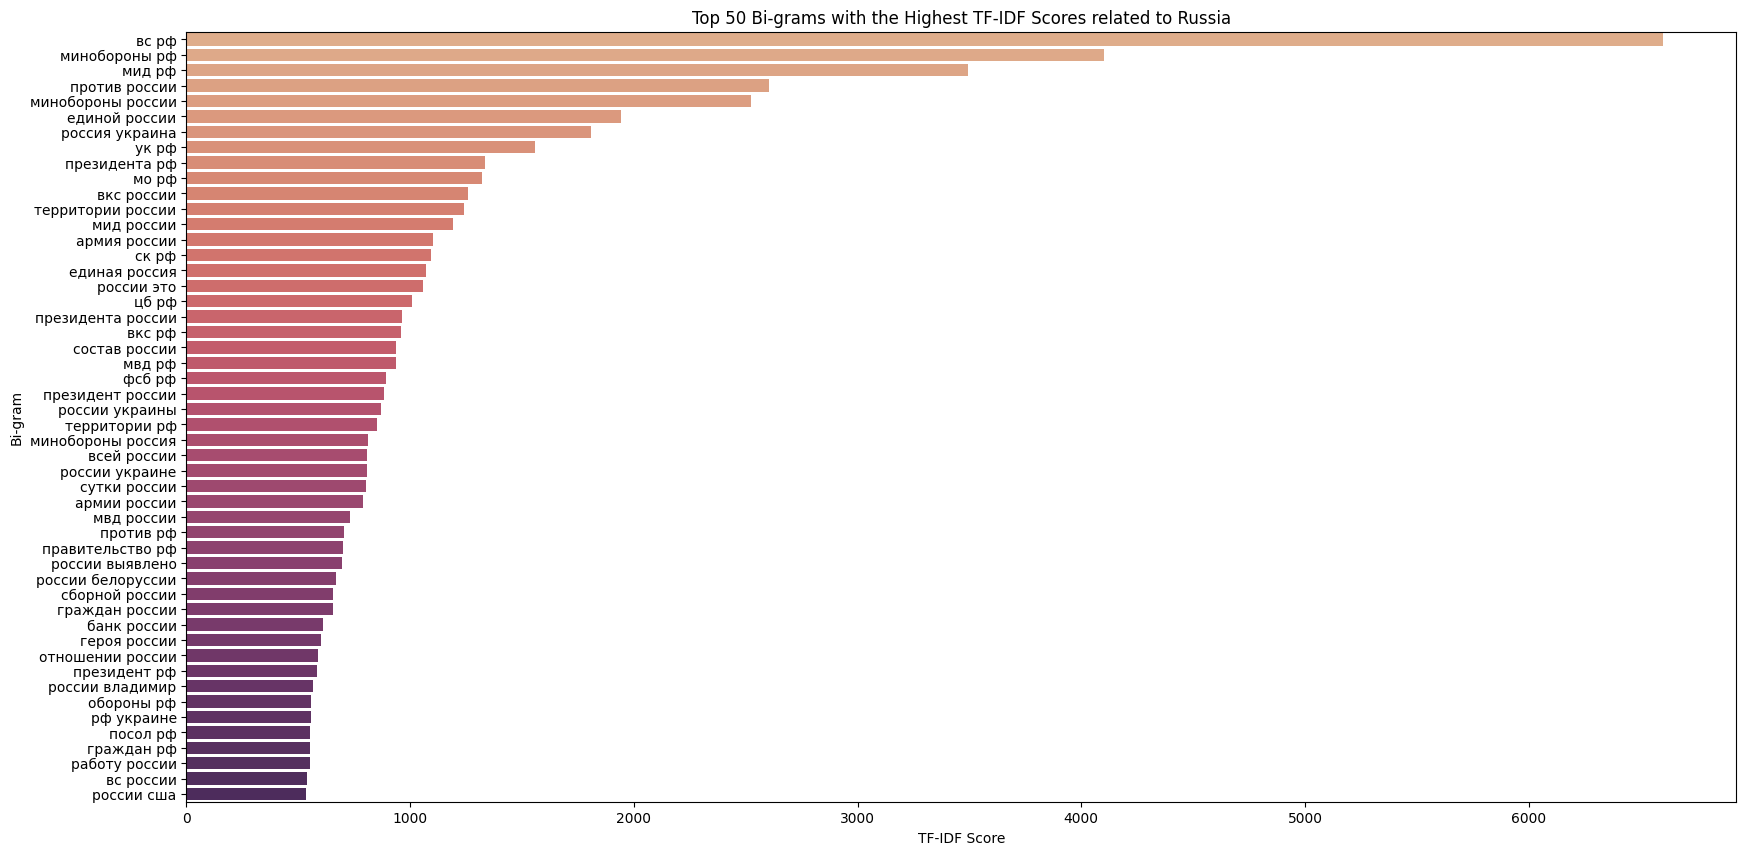

In [ ]:
# Filter bigrams for those containing 'россия', 'россии', 'рф', 'росийская федерация'
russia_related_bigrams = ranking[ranking['term'].str.contains('россия|россии|рф|росийская|росийской', regex=True)]

# Plotting the top bigrams related to Russia
plt.figure(figsize=(20, 10))
sns.barplot(x='rank', y='term', data=russia_related_bigrams.head(50), palette="flare")
plt.title('Top 50 Bi-grams with the Highest TF-IDF Scores related to Russia')
plt.xlabel('TF-IDF Score')
plt.ylabel('Bi-gram')
plt.show()

Assumptions:
- They relate Ukraine as part of russia
- Western world against russia narrative
- Maybe they try to assure that everything works well in russia
  - Mention different military structures of russia
  - Mentioned different ministires of russia
  - Mentioned russian banks (context might be related to sanctions)


## **Network Analysis**

### Can we identify clusters of channels that share similar content?

In [ ]:
import random
random.seed(148)

In [ ]:
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import community

all_texts = []
channel_texts = {}

top_median_views = aggregated_df.nlargest(200, 'median_views')

# Loop through each channel and aggregate messages
for channel in top_median_views['channel']:
    try:
        df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")
        if 'message' not in df.columns:
          print(f"Column 'message' not found in {channel}. Skipping to the next file.")
          continue
        # Concatenate all messages for a channel
        all_messages = ' '.join(df['message'].dropna())
        all_texts.append(all_messages)
        channel_texts[channel] = all_messages
    except FileNotFoundError:
        continue




In [ ]:
nltk.download('stopwords')
russian_stopwords = set(stopwords.words("russian"))

# Your custom stop words
custom_stopwords = ['t', 'me', 'ru', 'https','иностранного', 'агента', 'функции',
                           'выполняющим', 'массовой', 'информации',
                           'данное', 'сообщение', 'лицом',
                           'юридическим', 'cредством', 'материал', 'создано',
                           'распространено','иностранным', 'средством'
]
russian_stopwords.update(custom_stopwords)
russian_stopwords_list = list(russian_stopwords)

In [ ]:
# TF-IDF
vectorizer = TfidfVectorizer(stop_words=russian_stopwords_list, max_features=5000)
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# Network Construction
G = nx.Graph()


In [ ]:
from networkx.algorithms.community import girvan_newman

for channel in channel_texts.keys():
    G.add_node(channel)

# Add edges if cosine similarity is above a threshold (e.g., 0.5)
for i, channel1 in enumerate(channel_texts.keys()):
    for j, channel2 in enumerate(channel_texts.keys()):
        if i < j and cosine_sim[i, j] > 0.5:
            G.add_edge(channel1, channel2, weight=cosine_sim[i, j])

# Community Detection using girvan_newman
communities_generator = girvan_newman(G)
top_level_communities = next(communities_generator)
communities = {node: i for i, community in enumerate(top_level_communities) for node in community}
nx.set_node_attributes(G, communities, 'community')

In [ ]:
import plotly.graph_objects as go
import networkx as nx

pos = nx.spring_layout(G)  # positions for all nodes

# Edge trace
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Node trace
node_x = []
node_y = []
node_text = []
node_adjacencies = []  # List to store the degree of each node

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)
    node_adjacencies.append(len(list(G.neighbors(node))))  # Degree of the node

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=node_text,
    textposition="top center",
    textfont=dict(
        family="arial",
        size=10,
        color="black"
    ),
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        color=node_adjacencies,  # Use node degree for color
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Create figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph of channels',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                width=800,
                height=800,
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()


 - The figure show channels with similar messages content.

 - In figure, we can see "marginalized" channels and a big network cluster in the center.


 **Let's zoom it!**


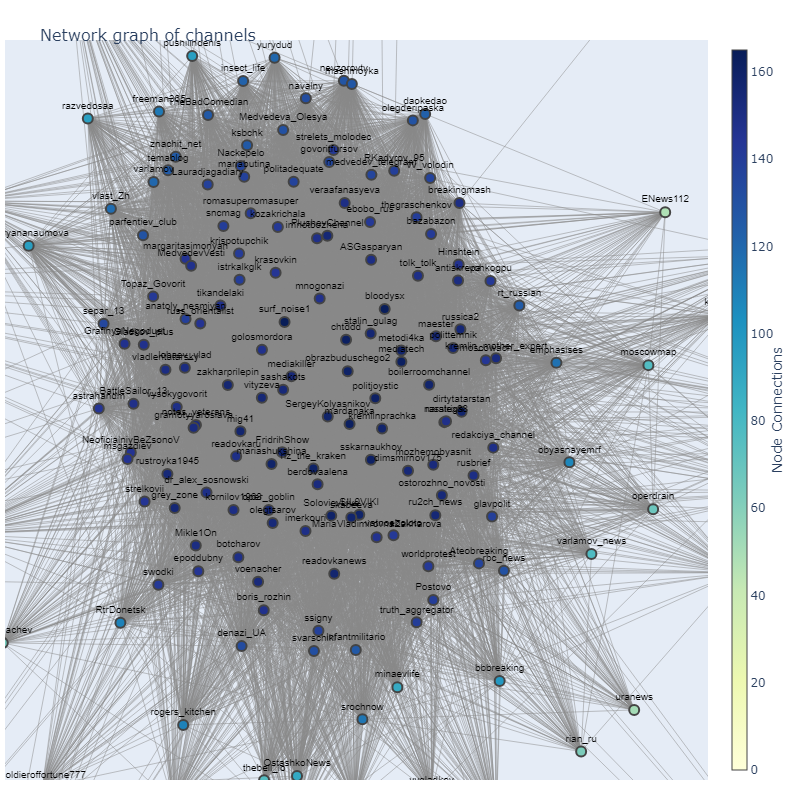

 As you can see, dud' and nevzorov are close to navaliy, and bad comedian. And they are not so far from medvedev and kadyrov. Vagners related channel "grey zone" is close to strelkov's.

 What I what tell: all russians are the same, the so-called "liberal russians" tell close narratives as russian politicians, even if they want to pretend that they are different.

 There are no "good russians", obviously. ML proves that.

### Can we identify clusters of channels based on bi-grams?

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import re
import gc
from collections import defaultdict
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from networkx.algorithms.community import girvan_newman

# Extract bigrams using the provided code
nltk.download('stopwords')
russian_stopwords = set(stopwords.words("russian"))

# Placeholder for bigram frequencies using a default dictionary
bigram_freq = defaultdict(int)

# Your custom stop words
custom_stopwords = ['t', 'me', 'ru', 'https','1','2','5']  # Add your words here

# Extend the NLTK's stop words list with your custom words
russian_stopwords.update(custom_stopwords)

# Your custom bigram stop words
custom_bigram_stopwords = [('иностранного', 'агента'), ('функции', 'иностранного'),
                           ('выполняющим', 'функции'),('массовой', 'информации'),
                           ('данное', 'сообщение'), ('лицом', 'выполняющим'),
                           ('юридическим', 'лицом'),('cредством','массовой'),
                           ('сообщение', 'материал'),('материал', 'создано'),
                           ('создано', 'распространено'),('иностранным', 'средством'),
                           ('российским', 'юридическим'),('информации', 'выполняющим'),
                           ('агента', 'российским'),('распространено','иностранным')]

# Define a chunk size
chunk_size = 1000
top_median_views = aggregated_df.nlargest(100, 'median_views')

# Loop through each channel and aggregate bigram frequencies
all_bigrams = []
bigram_texts = {}

for channel in top_median_views['channel']:
    try:
        # Read the CSV in chunks and only the 'message' column
        for chunk in pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv", usecols=['message'], chunksize=chunk_size):
            # Tokenize each message individually, remove stopwords, and update bigram frequencies
            for message in chunk['message'].dropna():
                words = [word for word in re.findall(r'\w+', message.lower()) if word not in russian_stopwords]
                bigram_list = [' '.join(bigram) for bigram in ngrams(words, 2) if bigram not in custom_bigram_stopwords]
                all_bigrams.extend(bigram_list)
                bigram_texts[channel] = ' '.join(bigram_list)

            # delete the chunk and collect garbage
            del chunk
            gc.collect()

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue



In [ ]:
# Compute the TF-IDF scores for these bigrams
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(2,2))
tfidf_matrix = vectorizer.fit_transform(list(bigram_texts.values()))

# Compute cosine similarity between channels based on bigram TF-IDF scores
cosine_sim = cosine_similarity(tfidf_matrix)


In [ ]:
import plotly.graph_objects as go
import networkx as nx

# Construct the network as before
G = nx.Graph()
for channel in bigram_texts.keys():
    G.add_node(channel)
for i, channel1 in enumerate(bigram_texts.keys()):
    for j, channel2 in enumerate(bigram_texts.keys()):
        if i < j and cosine_sim[i, j] > 0.1:
            G.add_edge(channel1, channel2, weight=cosine_sim[i, j])

# Position the nodes using a layout algorithm
pos = nx.spring_layout(G)

# Create edge traces
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create node traces
node_x = []
node_y = []
node_text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=node_text,
    textposition="top center",
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        color=[len(list(G.neighbors(n))) for n in G.nodes()],
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>Network graph of channel similarity based on Bi-grams',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    width=1000,
                    height=1000,
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002)],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()


- The figure shows channels with similar frequently used Bigrams in messages.

- Even with a low threshold for cosine similarity, we don't see strong networks here. It means that frequent bi-grams are different for popular propagandist channels.

- To identify similar narratives, using vectorized messages(like we did before) instead of vectorized frequent bigrams is better.



## **Time Series**

### How has the posting frequency changed over time?


In [ ]:
import plotly.graph_objects as go

# Placeholder for storing posting frequencies for each week
week_frequencies = defaultdict(list)

# Loop through each channel
for channel in channel_names:
    try:
        df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")
        if 'date' not in df.columns:
          print(f"Column 'date' not found in {channel}. Skipping to the next file.")
          continue
        # Convert the date column to datetime format
        df['date'] = pd.to_datetime(df['date'])

        # Resample the data to get weekly counts
        weekly_counts = df.resample('W-Mon', on='date').size()

        # Update the frequencies list for each week
        for week, count in weekly_counts.items():
            week_frequencies[week].append(count)
    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue

# Compute the median posting frequency for each week
weeks = sorted(week_frequencies.keys())
medians = [np.median(week_frequencies[week]) for week in weeks]

# Plotting using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=weeks, y=medians, mode='lines', name='Median Posting Frequency'))

fig.update_layout(title='Median Posting Frequency Over Time (Weekly)',
                  xaxis_title='Week',
                  yaxis_title='Median Posting Frequency',
                  xaxis=dict(showgrid=True),
                  yaxis=dict(showgrid=True))

fig.show()


<ipython-input-7-8117d9af74f9>:12: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")
<ipython-input-7-8117d9af74f9>:12: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")
<ipython-input-7-8117d9af74f9>:12: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")
<ipython-input-7-8117d9af74f9>:12: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")


Column 'date' not found in rybar. Skipping to the next file.


- As we can see posting frequency had peak when the war started.
- During April (after russins withdraw from Kyiv's region) we observe steep decline that ended in May.
- We can see smaller peak in September (Kharkiv region liberation).

### How do reactions vary over time?

In [ ]:
import plotly.express as px

# Define positive and negative reactions
positive_reactions = ['👍', '🔥','❤\u200d🔥', '👏', '🤣', '🥰', '😁', '❤','🎉']
negative_reactions = ['👎', '🤬', '💩', '🤮', '🤡','😢','😱']

# Placeholder for the data
reactions_data = []

# Regular expression pattern to extract reactions and their counts
pattern = r"ReactionCount\(reaction='(.*?)', count=(\d+),"

# Loop through each channel and aggregate reactions
for channel in channel_names:
    try:
        df = pd.read_csv(f"/content/gdrive/My Drive/Colab Notebooks/channels/{channel}.csv")

        # Check if 'reactions' column exists in the DataFrame
        if 'reactions' not in df.columns:
            print(f"Column 'reactions' not found in {channel}. Skipping to the next file.")
            continue

        # Extract reactions and their counts for each post
        df['reactions_dict'] = df['reactions'].apply(lambda x: dict(re.findall(pattern, str(x))) if pd.notnull(x) else {})

        # Calculate the sum of counts for positive and negative reactions for each post
        df['positive_reactions'] = df['reactions_dict'].apply(lambda x: sum([int(x[reaction]) for reaction in positive_reactions if reaction in x]))
        df['negative_reactions'] = df['reactions_dict'].apply(lambda x: sum([int(x[reaction]) for reaction in negative_reactions if reaction in x]))

        # Append to the reactions_data list
        temp_df = df[['date', 'positive_reactions', 'negative_reactions']].copy()
        reactions_data.append(temp_df)

    except FileNotFoundError:
        print(f"File {channel}.csv not found. Skipping to the next channel.")
        continue

# Concatenate all dataframes
reactions_df = pd.concat(reactions_data, ignore_index=True)

# Convert 'date' column to datetime format
reactions_df['date'] = pd.to_datetime(reactions_df['date'])


In [ ]:
weekly_reactions_2022 = weekly_reactions[weekly_reactions['date'].dt.year >= 2022]

# Plotting
fig = px.line(weekly_reactions_2022, x='date', y=['positive_reactions', 'negative_reactions'], title='Weekly Positive and Negative Reactions Over Time (From 2022 Onwards)', labels={'value': 'Number of Reactions', 'variable': 'Reaction Type'})
fig.show()

- Positive reactions prevails over negative. Which is how propaganda works.
- Assumed that peaks of negative reactions might be related to Kyiv region liberation (beginning of April). Kharkiv region liberation and Lyman city in September.
- Sources of positive reaction in russia on April 18-25 related to the start of offensive operation in the Eastern operational zone and occupation of several cities in the East of Ukraine. Positive reactions on 10 - 17 October related to massive missile strike for Ukrainian energy and civilian infrastructure. As you can see, those creatures like to see us suffer.